In [149]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Imports de la libreria propia
from vecopsciml.kernels.derivative import DerivativeKernels
from vecopsciml.utils import TensOps
from vecopsciml.operators import zero_order as zo
from vecopsciml.algebra import zero_order as azo

# Imports de las funciones creadas para este programa
from models.non_constant_diffusivity import NonConstantDiffusivityNeuralNetwork
from utils.folders import create_folder
from utils.load_data import load_data
from utils.checkpoints import load_results
from trainers.train import train_loop

In [150]:
# Creamos los paths para las distintas carpetas
ROOT_PATH = r'C:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning'
DATA_PATH = os.path.join(ROOT_PATH, r'data\non_linear\non_linear.pkl')
RESULTS_FOLDER_PATH = os.path.join(ROOT_PATH, r'results\non_linear')
MODEL_RESULTS_PATH = os.path.join(ROOT_PATH, r'results\non_linear\modelo_prueba_2')

# Creamos las carpetas que sean necesarias (si ya están creadas se avisará de ello)
create_folder(RESULTS_FOLDER_PATH)
create_folder(MODEL_RESULTS_PATH)

Folder already exists at: C:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\results\non_linear
Folder already exists at: C:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\results\non_linear\modelo_prueba_2


In [151]:
# Load dataset
dataset = load_data(DATA_PATH)

Data successfully loaded from: C:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\data\non_linear\non_linear.pkl


In [152]:
# Convolutional filters to derivate
dx = dataset['x_step_size']
dy = dataset['y_step_size']
D = DerivativeKernels(dx, dy, 0).grad_kernels_two_dimensions()

In [153]:
# Tratamiento de los datos para dividirlos en train y test
X_train = torch.Tensor(dataset['X_train']).unsqueeze(1)
y_train = TensOps(torch.tensor(dataset['y_train'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)
K_train = TensOps(torch.tensor(dataset['k_train'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)

X_val = torch.Tensor(dataset['X_val']).unsqueeze(1)
y_val = TensOps(torch.tensor(dataset['y_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)
K_val = TensOps(torch.tensor(dataset['k_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)

X_np = X_train
y_np = y_train.values
K_np = K_train.values

X_train_np, X_test_np, y_train_np, y_test_np, K_train_np, K_test_np = train_test_split(X_np, y_np, K_np, test_size=0.2, random_state=42)

X_train = X_train_np
X_test = X_test_np

y_train = TensOps(y_train_np, space_dimension=y_train.space_dim, contravariance=0, covariance=0)
y_test = TensOps(y_test_np, space_dimension=y_train.space_dim, contravariance=0, covariance=0)

K_train = TensOps(K_train_np, space_dimension=K_train.space_dim, contravariance=0, covariance=0)
K_test = TensOps(K_test_np, space_dimension=K_train.space_dim, contravariance=0, covariance=0)

In [154]:
# Arquitectura del modelo
input_shape = X_train[0].shape  # [1, 10, 8]
hidden1_dim = 20
hidden2_dim = 20
output_shape = y_train.values[0].shape  # [1, 10, 10]

In [155]:
# Se carga el modelo y el optimizador
model = NonConstantDiffusivityNeuralNetwork(input_shape, hidden1_dim, hidden2_dim, output_shape)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

model, optimizer, lists = load_results(model, optimizer, MODEL_RESULTS_PATH)


In [156]:
train_total_loss_list = lists['train_total_loss_list']
train_e_loss_list = lists['train_e_loss_list']
train_pi1_loss_list = lists['train_pi1_loss_list']
train_pi2_loss_list = lists['train_pi2_loss_list']
train_pi3_loss_list = lists['train_pi3_loss_list']

test_total_loss_list = lists['test_total_loss_list']
test_e_loss_list = lists['test_e_loss_list']
test_pi1_loss_list = lists['test_pi1_loss_list']
test_pi2_loss_list = lists['test_pi2_loss_list']
test_pi3_loss_list = lists['test_pi3_loss_list']

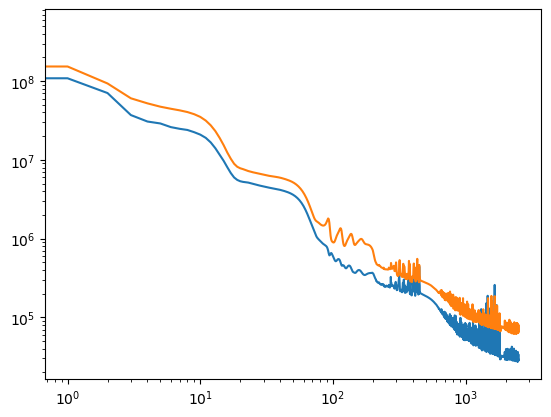

In [157]:
plt.plot(train_total_loss_list)
plt.plot(test_total_loss_list)
plt.xscale('log')
plt.yscale('log')
plt.show()

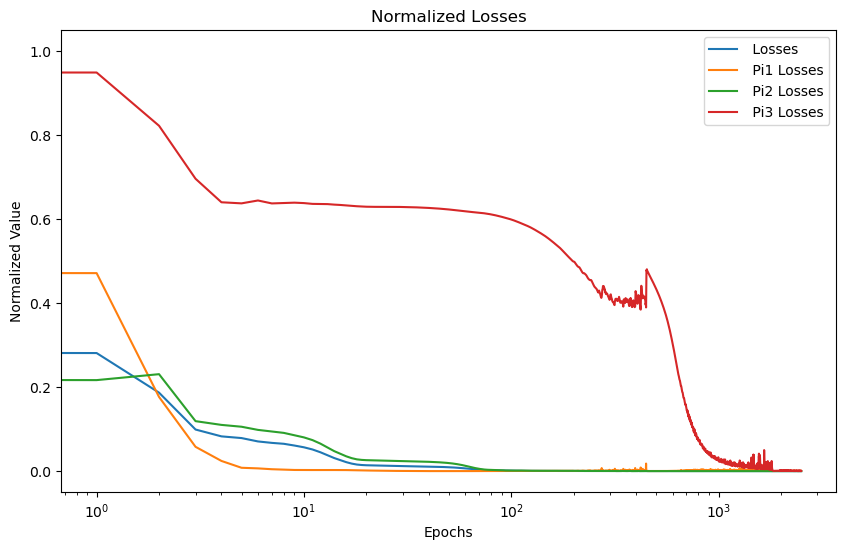

In [158]:
# Función para normalizar listas
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# Normalizar las listas
normalized_e_losses = normalize(np.array(train_e_loss_list))
normalized_pi1_losses = normalize(np.array(train_pi1_loss_list))
normalized_pi2_losses = normalize(np.array(train_pi2_loss_list))
normalized_pi3_losses = normalize(np.array(train_pi3_loss_list))

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(normalized_e_losses, label=' Losses')
plt.plot(normalized_pi1_losses, label=' Pi1 Losses')
plt.plot(normalized_pi2_losses, label=' Pi2 Losses')
plt.plot(normalized_pi3_losses, label=' Pi3 Losses')

# Añadir leyenda y etiquetas
plt.title('Normalized Losses')
plt.xlabel('Epochs')
plt.ylabel('Normalized Value')
plt.legend()
plt.xscale('log')
# plt.yscale('log')
# plt.grid()

In [159]:
def relative_error_stats(validation, prediction, dx=dx, dy=dy):

    validation = validation.numpy()
    prediction = prediction.numpy()

    prediction_error = np.sqrt((np.trapz(np.trapz((validation - prediction)**2, dx=dy), dx=dx) /
                                np.trapz(np.trapz((validation)**2, dx=dy), dx=dx)))

    minimo = np.min(prediction_error)
    maximo = np.max(prediction_error)
    primer_cuartil = np.percentile(prediction_error, 25)
    mediana = np.percentile(prediction_error, 50)
    tercer_cuartil = np.percentile(prediction_error, 75)

    # Imprimir los resultados
    print(f"Mínimo: {minimo:.2e}")
    print(f"Máximo: {maximo:.2e}")
    print(f"Primer cuartil (Q1): {primer_cuartil:.2e}")
    print(f"Mediana (Q2): {mediana:.2e}")
    print(f"Tercer cuartil (Q3): {tercer_cuartil:.2e}")

In [160]:
y_pred, K_pred = model(X_val)

y_pred = TensOps(y_pred, space_dimension=2, contravariance=0, covariance=0)
K_pred = TensOps(K_pred, space_dimension=2, contravariance=0, covariance=0)

In [161]:
u_validation = y_val.values.detach()
u_prediction = y_pred.values.detach()

relative_error_stats(u_validation, u_prediction)

Mínimo: 1.36e-03
Máximo: 3.44e-02
Primer cuartil (Q1): 2.33e-03
Mediana (Q2): 2.77e-03
Tercer cuartil (Q3): 3.97e-03


In [162]:
K_validation = zo.My(zo.Mx(K_val)).values.detach()
K_prediction = K_pred.values.detach()

relative_error_stats(K_validation, K_prediction)

Mínimo: 3.10e-02
Máximo: 5.72e-01
Primer cuartil (Q1): 1.19e-01
Mediana (Q2): 1.82e-01
Tercer cuartil (Q3): 2.48e-01


In [163]:
qx_validation = zo.Mx(zo.My(TensOps(torch.Tensor(dataset['qx_val']).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0))).values.detach()
qx_prediction = azo.scalar_product(K_pred, zo.Dx(y_pred, D)).values.detach()

relative_error_stats(qx_validation, qx_prediction)

Mínimo: 2.53e-02
Máximo: 6.08e+00
Primer cuartil (Q1): 1.35e-01
Mediana (Q2): 2.06e-01
Tercer cuartil (Q3): 2.83e-01


In [164]:
qy_validation = zo.Mx(zo.My(TensOps(torch.Tensor(dataset['qy_val']).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0))).values.detach()
qy_prediction = azo.scalar_product(K_pred, zo.Dy(y_pred, D)).values.detach()

relative_error_stats(qy_validation, qy_prediction)

Mínimo: 3.23e-02
Máximo: 1.13e+02
Primer cuartil (Q1): 1.39e-01
Mediana (Q2): 2.09e-01
Tercer cuartil (Q3): 2.80e-01
